# classification-18

## What's new:

1- https://claude.ai/chat/f641b5d3-0bf4-463f-92db-a02f95f027ef


## next step:

1-


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Input, Reshape, Lambda, Dropout, BatchNormalization
from tensorflow.keras import Input, layers, models, callbacks, metrics
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models, callbacks
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from sklearn.model_selection import train_test_split
from scipy.signal import savgol_filter, find_peaks, peak_prominences
from sklearn.preprocessing import RobustScaler
from sklearn.utils.class_weight import compute_class_weight

import joblib
import json
import os


2025-11-28 18:50:55.722387: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764343255.760277    3227 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764343255.769340    3227 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1764343255.836407    3227 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764343255.836438    3227 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764343255.836440    3227 computation_placer.cc:177] computation placer alr

In [2]:
# 1- Load and Scaling Features

df = pd.read_csv('XAGUSD-197001010000--H1-rates.csv', sep='\t')
# Rename columns for easier access
df.rename(columns={
    '<DATE>': 'DATE',
    '<TIME>': 'TIME',
    '<OPEN>': 'OPEN',
    '<HIGH>': 'HIGH',
    '<LOW>': 'LOW',
    '<CLOSE>': 'CLOSE',
    '<TICKVOL>': 'TICKVOL',
    '<VOL>': 'VOL',
    '<SPREAD>': 'SPREAD'
}, inplace=True)

# ensure strings and strip any weird whitespace
df['DATE'] = df['DATE'].astype(str).str.strip()
df['TIME'] = df['TIME'].astype(str).str.strip()

df['DATETIME'] = pd.to_datetime(df['DATE'] + ' ' + df['TIME'], dayfirst=False, errors='coerce')
if df['DATETIME'].isna().any():
    raise ValueError("Some DATETIME values could not be parsed. Check date/time formats.")

# set DATETIME as index for reindexing
df = df.set_index('DATETIME').sort_index()

# --------------------------
# Create continuous hourly index & fill weekend gaps
# --------------------------
full_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='h')

# Reindex to full hourly range so weekends/missing hours appear as NaN rows
df = df.reindex(full_index)

# Fill strategy:
# - Prices: forward-fill last known price across weekend gap (common approach for modeling continuity).
# - TICKVOL / VOL: set missing to 0 (no ticks during weekend).
# - SPREAD: forward-fill last known.
# Alternative: you could leave NaNs and drop sequences that cross weekends (safer but reduces data).
df[['OPEN', 'HIGH', 'LOW', 'CLOSE']] = df[['OPEN', 'HIGH', 'LOW', 'CLOSE']].ffill()
df['SPREAD'] = df['SPREAD'].ffill()
df['TICKVOL'] = df['TICKVOL'].fillna(0)
df['VOL'] = df['VOL'].fillna(0)

# Reset index to make DATETIME a regular column again
df = df.reset_index().rename(columns={'index': 'DATETIME'})

In [3]:
df.shape

(179856, 10)

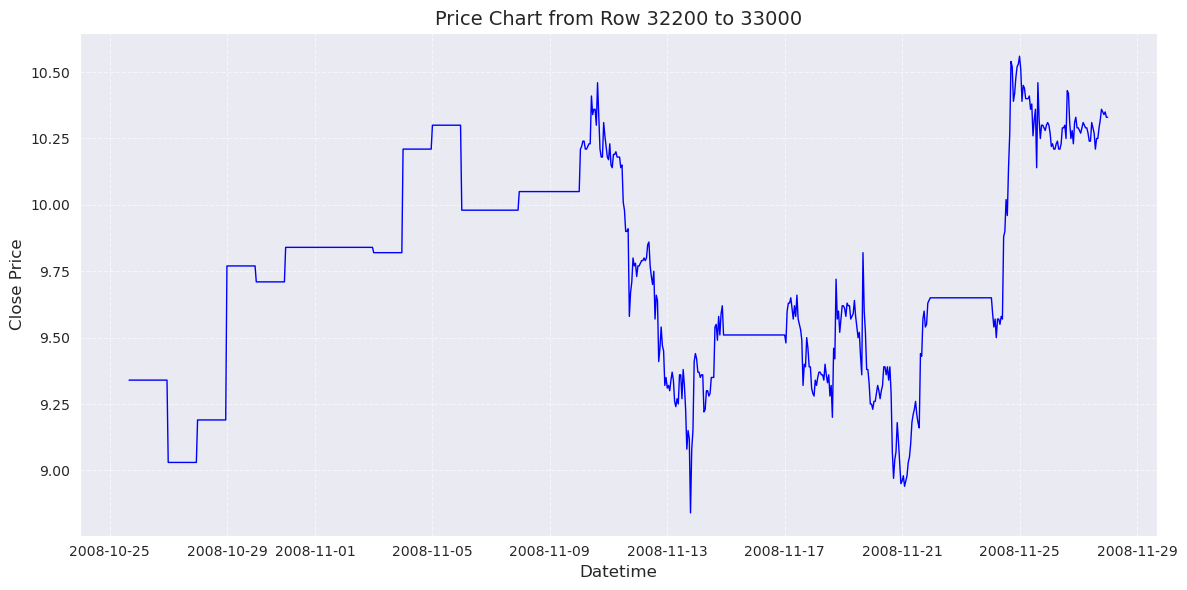

In [4]:
# Example: choose the start and end rows
start_row = 32200
end_row = 33000

# Select the range and make a copy to avoid SettingWithCopyWarning
subset = df.iloc[start_row:end_row + 1].copy()

# Ensure DATETIME is datetime type
subset['DATETIME'] = pd.to_datetime(subset['DATETIME'])

# Plot CLOSE price over time
plt.figure(figsize=(12, 6))
plt.plot(subset['DATETIME'], subset['CLOSE'], linewidth=1.0, color='blue')

# Labels and formatting
plt.title(f"Price Chart from Row {start_row} to {end_row}", fontsize=14)
plt.xlabel("Datetime", fontsize=12)
plt.ylabel("Close Price", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [5]:
# Specify how many rows to remove for model
nn = 33000  # Delete the first nn rows that do not follow the one-hour timeframe.
mm = 500  # Remove mm last row that the model should not see.

# Delete first nn and last mm rows
df_model = df.iloc[nn:len(df) - mm].reset_index(drop=True)

In [6]:
def label_reversal_points(
        close,
        high=None,
        low=None,
        smoothing_window=31,
        polyorder=3,
        base_prom_factor=0.02,
        distance=3,
        snap_window=5,
        min_dev_pct=0.0015,  # 0.15% minimum leg size
        min_dev_sigma=2.0,  # >= 2x local abs-return EMA
        vol_window=100,  # EMA window for local volatility
        verbose=False
):
    """
    Label reversal points with improved accuracy.

    Returns labels array of length n where:
    0 = none, 1 = valley, 2 = peak.

    Tips:
    - For best accuracy, pass high/low arrays from your OHLCV.
      Example: label_reversal_points(df['CLOSE'], df['HIGH'], df['LOW'])
    - Tune min_dev_pct / min_dev_sigma to be stricter or looser on swing size.
    """
    close = np.asarray(close, dtype=float)
    n = close.size
    if n < 3:
        return np.zeros(n, dtype=int)

    # Interpolate NaNs if any
    if np.isnan(close).any():
        idx = np.arange(n)
        good = ~np.isnan(close)
        close = close.copy()
        close[~good] = np.interp(idx[~good], idx[good], close[good])

    # Helper: simple EMA for local abs-return volatility
    def ema(x, span):
        x = np.asarray(x, dtype=float)
        alpha = 2.0 / (span + 1.0)
        out = np.empty_like(x)
        out[0] = x[0]
        for i in range(1, len(x)):
            out[i] = alpha * x[i] + (1 - alpha) * out[i - 1]
        return out

    # Local volatility in price terms via EMA of absolute returns
    ret = np.zeros(n)
    ret[1:] = np.abs(np.diff(close) / np.maximum(1e-12, close[:-1]))
    vol_absret = ema(ret, vol_window)
    local_vol_price = vol_absret * close  # convert to price units

    # Smoothing to get robust candidates
    win = smoothing_window
    if win >= n:
        win = n - 1 if (n - 1) % 2 == 1 else n - 2
    if win % 2 == 0:
        win += 1
    smoothed = savgol_filter(close, win, polyorder)

    # Base prominence threshold
    global_std = np.std(close) or 1.0
    prom = global_std * base_prom_factor

    # Candidate peaks/valleys on smoothed
    peak_idx, _ = find_peaks(smoothed, distance=distance, prominence=prom)
    val_idx, _ = find_peaks(-smoothed, distance=distance, prominence=prom)

    # Prominences for tie-breaking
    peak_prom = peak_prominences(smoothed, peak_idx)[0] if peak_idx.size else np.array([])
    val_prom = peak_prominences(-smoothed, val_idx)[0] if val_idx.size else np.array([])

    # Combine
    candidates = []
    for i, p in enumerate(peak_idx):
        candidates.append((int(p), 2, float(peak_prom[i]) if peak_prom.size else 0.0))
    for i, v in enumerate(val_idx):
        candidates.append((int(v), 1, float(val_prom[i]) if val_prom.size else 0.0))
    candidates.sort(key=lambda x: x[0])

    if not candidates:
        labels = np.zeros(n, dtype=int)
        # still mark edges for completeness
        labels[0] = 1 if close[1] > close[0] else 2
        labels[-1] = 1 if close[-1] > close[-2] else 2
        return labels

    # Enforce alternation (remove weaker when two same-type neighbors)
    def enforce_alternation(ext):
        ext = ext[:]  # list of (idx, typ, prom)
        while True:
            removed = False
            i = 0
            while i < len(ext) - 1:
                if ext[i][1] == ext[i + 1][1]:
                    # drop the smaller prominence
                    if ext[i][2] < ext[i + 1][2]:
                        ext.pop(i)
                    else:
                        ext.pop(i + 1)
                    removed = True
                else:
                    i += 1
            if not removed:
                break
        return ext

    candidates = enforce_alternation(candidates)

    # SNAP: move each extreme to the true local extremum on raw close (or HIGH/LOW)
    def snap_index(idx, typ):
        L = max(0, idx - snap_window)
        R = min(n, idx + snap_window + 1)
        if high is not None and low is not None:
            if typ == 2:  # peak
                j = np.argmax(np.asarray(high[L:R], dtype=float))
            else:  # valley
                j = np.argmin(np.asarray(low[L:R], dtype=float))
        else:
            if typ == 2:
                j = np.argmax(close[L:R])
            else:
                j = np.argmin(close[L:R])
        return L + int(j)

    snapped = []
    seen_at = {}  # avoid duplicate indices by keeping stronger prominence
    for idx, typ, pr in candidates:
        j = snap_index(idx, typ)
        key = (j, typ)
        if key not in seen_at or pr > seen_at[key][2]:
            seen_at[key] = (j, typ, pr)
    snapped = sorted(seen_at.values(), key=lambda x: x[0])

    # Enforce alternation again after snapping
    snapped = enforce_alternation(snapped)

    # Filter micro-legs using adaptive threshold (min % move and sigma*local_vol)
    pruned = []
    for idx, typ, pr in snapped:
        if not pruned:
            pruned.append((idx, typ, pr))
            continue
        prev_idx, prev_typ, prev_pr = pruned[-1]
        # time spacing
        if idx - prev_idx < distance:
            # keep the more prominent of the two
            if pr > prev_pr:
                pruned[-1] = (idx, typ, pr)
            continue
        leg = abs(close[idx] - close[prev_idx])
        # thresholds at both ends
        thr = max(min_dev_pct * close[prev_idx],
                  min_dev_sigma * max(local_vol_price[prev_idx], 1e-12))
        thr = max(thr, max(min_dev_pct * close[idx],
                           min_dev_sigma * max(local_vol_price[idx], 1e-12)))
        if leg >= thr:
            pruned.append((idx, typ, pr))
        else:
            # too small swing → drop the later point
            continue

    # One more alternation pass (paranoid) and spacing check
    pruned = enforce_alternation(pruned)
    final_ext = []
    for idx, typ, pr in pruned:
        if final_ext and idx - final_ext[-1][0] < distance:
            # keep stronger
            if pr > final_ext[-1][2]:
                final_ext[-1] = (idx, typ, pr)
        else:
            final_ext.append((idx, typ, pr))

    # Build labels
    labels = np.zeros(n, dtype=int)
    for idx, typ, _ in final_ext:
        labels[idx] = typ

    # Mark edges as trend boundaries for continuity
    if labels[0] == 0:
        labels[0] = 1 if close[min(1, n - 1)] > close[0] else 2
    if labels[-1] == 0 and n >= 2:
        labels[-1] = 1 if close[-1] > close[-2] else 2

    if verbose:
        c0 = int((labels == 0).sum())
        c1 = int((labels == 1).sum())
        c2 = int((labels == 2).sum())
        print(f"labels -> 0:{c0}  1:{c1}  2:{c2}  (extrema kept: {len(final_ext)})")

    return labels


In [7]:
# baseline (close-only)
df_model['Label'] = label_reversal_points(df_model['CLOSE'].values, verbose=True)

# inspect counts
print(df_model['Label'].value_counts())

labels -> 0:144229  1:1063  2:1064  (extrema kept: 2125)
Label
0    144229
2      1064
1      1063
Name: count, dtype: int64


In [8]:
# Display label distribution in df_model
label_counts = df_model['Label'].value_counts().sort_index()
label_percentages = (df_model['Label'].value_counts(normalize=True) * 100).sort_index()

print("Label Distribution in df_model:")
print("-" * 40)
for label in sorted(df_model['Label'].unique()):
    count = label_counts[label]
    percentage = label_percentages[label]
    print(f"Class {label}: {count:,} rows ({percentage:.2f}%)")
print("-" * 40)
print(f"Total rows: {len(df_model):,}")


Label Distribution in df_model:
----------------------------------------
Class 0: 144,229 rows (98.55%)
Class 1: 1,063 rows (0.73%)
Class 2: 1,064 rows (0.73%)
----------------------------------------
Total rows: 146,356


In [9]:
def plot_labeled_candles(df_model, n=1000):
    """
    Plots the last n candles with BUY/SELL labels based on the 'Label' column.
    Assumes df already has a 'DATETIME' column.
    """
    # Drop NaN rows (e.g., weekend gaps)
    df_plot = df_model.dropna(subset=['CLOSE']).tail(n).copy()

    # Ensure DATETIME is a datetime column (optional safeguard)
    if not pd.api.types.is_datetime64_any_dtype(df_plot['DATETIME']):
        df_plot['DATETIME'] = pd.to_datetime(df_plot['DATETIME'])

    # === Plot Close Price ===
    plt.figure(figsize=(15, 6))
    plt.plot(df_plot['DATETIME'], df_plot['CLOSE'], label='Close Price', color='black', linewidth=1.5)

    # === Plot BUY (1) and SELL (2) signals ===
    for _, row in df_plot.iterrows():
        if row['Label'] == 1:  # BUY
            plt.axvline(x=row['DATETIME'], color='green', linestyle='--', linewidth=1)
            plt.text(row['DATETIME'], row['CLOSE'], 'BUY', color='green', ha='center', va='bottom', fontsize=9)
        elif row['Label'] == 2:  # SELL
            plt.axvline(x=row['DATETIME'], color='red', linestyle='--', linewidth=1)
            plt.text(row['DATETIME'], row['CLOSE'], 'SELL', color='red', ha='center', va='top', fontsize=9)

    # === Aesthetics ===
    plt.title(f'Last {n} Candles with Trend Reversal Labels')
    plt.xlabel('Datetime')
    plt.ylabel('Close Price')
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.legend()
    plt.show()



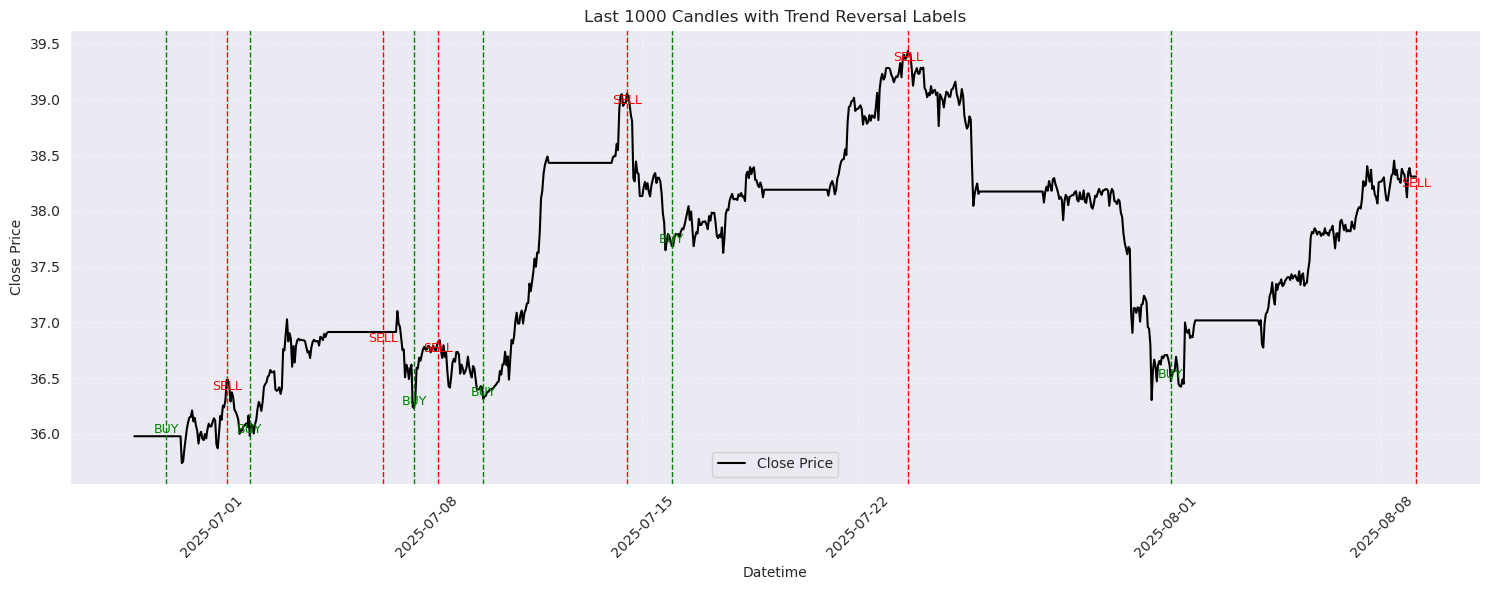

In [10]:
plot_labeled_candles(df_model)

In [11]:
# =============================================================================
# CONFIGURATION
# =============================================================================

WINDOW_SIZE = 60
FORECAST_HORIZON = 10
FEATURES = ['OPEN', 'HIGH', 'LOW', 'CLOSE', 'TICKVOL']
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [12]:
# =============================================================================
# DATA PREPARATION FUNCTIONS
# =============================================================================

def create_features(df, features=FEATURES):
    """Create technical indicators and normalize features"""
    df = df.copy()

    # Price-based features
    df['price_range'] = (df['HIGH'] - df['LOW']) / df['CLOSE']
    df['body_range'] = abs(df['CLOSE'] - df['OPEN']) / df['CLOSE']
    df['upper_shadow'] = (df['HIGH'] - df[['OPEN', 'CLOSE']].max(axis=1)) / df['CLOSE']
    df['lower_shadow'] = (df[['OPEN', 'CLOSE']].min(axis=1) - df['LOW']) / df['CLOSE']

    # Returns
    df['return_1h'] = df['CLOSE'].pct_change(1)
    df['return_3h'] = df['CLOSE'].pct_change(3)
    df['return_6h'] = df['CLOSE'].pct_change(6)

    # Momentum indicators
    df['rsi_14'] = compute_rsi(df['CLOSE'], 14)
    df['momentum_5'] = df['CLOSE'] / df['CLOSE'].shift(5) - 1

    # Volatility
    df['volatility_10'] = df['return_1h'].rolling(10).std()
    df['atr_14'] = compute_atr(df, 14)

    # Volume features
    df['volume_ma_ratio'] = df['TICKVOL'] / df['TICKVOL'].rolling(20).mean()

    # Moving averages and crossovers
    df['sma_10'] = df['CLOSE'].rolling(10).mean()
    df['sma_30'] = df['CLOSE'].rolling(30).mean()
    df['ma_cross'] = (df['sma_10'] - df['sma_30']) / df['CLOSE']

    # Price position
    df['price_position'] = (df['CLOSE'] - df['LOW'].rolling(20).min()) / \
                           (df['HIGH'].rolling(20).max() - df['LOW'].rolling(20).min())

    return df


def compute_rsi(series, period=14):
    """Compute Relative Strength Index"""
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))


def compute_atr(df, period=14):
    """Compute Average True Range"""
    high_low = df['HIGH'] - df['LOW']
    high_close = abs(df['HIGH'] - df['CLOSE'].shift())
    low_close = abs(df['LOW'] - df['CLOSE'].shift())
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = ranges.max(axis=1)
    return true_range.rolling(period).mean() / df['CLOSE']


def prepare_sequences(df, window_size=WINDOW_SIZE, forecast_horizon=FORECAST_HORIZON):
    """Create sequences for training with multi-step output"""
    feature_cols = [col for col in df.columns if col not in ['DATETIME', 'DATE', 'TIME', 'Label']]

    X, y = [], []
    for i in range(len(df) - window_size - forecast_horizon + 1):
        X.append(df[feature_cols].iloc[i:i + window_size].values)
        # Get labels for the next FORECAST_HORIZON steps
        y.append(df['Label'].iloc[i + window_size:i + window_size + forecast_horizon].values)

    return np.array(X), np.array(y)

In [13]:
# =============================================================================
# FOCAL LOSS FOR IMBALANCED DATA
# =============================================================================

@tf.keras.utils.register_keras_serializable(package="Custom")
class FocalLoss(tf.keras.losses.Loss):
    """Focal Loss to handle extreme class imbalance"""

    def __init__(self, alpha=None, gamma=2.0, from_logits=False, **kwargs):
        super().__init__(**kwargs)
        self.alpha = alpha
        self.gamma = gamma
        self.from_logits = from_logits

    def get_config(self):
        config = super().get_config()
        config.update({
            "alpha": self.alpha,
            "gamma": self.gamma,
            "from_logits": self.from_logits,
        })
        return config

    def call(self, y_true, y_pred):
        if self.from_logits:
            y_pred = tf.nn.softmax(y_pred, axis=-1)

        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)

        y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), depth=3)
        cross_entropy = -y_true_one_hot * tf.math.log(y_pred)

        focal_weight = tf.pow(1 - y_pred, self.gamma)
        focal_cross_entropy = focal_weight * cross_entropy

        if self.alpha is not None:
            alpha_weight = y_true_one_hot * self.alpha
            focal_cross_entropy = alpha_weight * focal_cross_entropy

        return tf.reduce_mean(tf.reduce_sum(focal_cross_entropy, axis=-1))




In [14]:
# =============================================================================
# MODEL ARCHITECTURE
# =============================================================================

def build_reversal_model(input_shape, num_classes=3):
    """
    Multi-head attention model with CNN feature extraction for reversal prediction
    """
    inputs = layers.Input(shape=input_shape)

    # CNN feature extraction
    x = layers.Conv1D(64, 3, padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv1D(128, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv1D(256, 3, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(0.3)(x)

    # Multi-head attention
    attention = layers.MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
    x = layers.Add()([x, attention])
    x = layers.LayerNormalization()(x)

    # Bidirectional LSTM
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Bidirectional(layers.LSTM(64))(x)
    x = layers.Dropout(0.4)(x)

    # Dense layers
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.4)(x)

    # Output layer for FORECAST_HORIZON predictions
    outputs = layers.Dense(FORECAST_HORIZON * num_classes, activation='softmax')(x)
    outputs = layers.Reshape((FORECAST_HORIZON, num_classes))(outputs)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [15]:
# =============================================================================
# TRAINING WITH SMOTE-LIKE OVERSAMPLING
# =============================================================================

def oversample_minority_classes(X, y, target_ratio=0.15):
    """
    Oversample minority classes (1 and 2) by duplicating with slight noise
    """
    # Flatten y to find minority samples
    y_flat = y.reshape(-1)

    indices_class_1 = np.where(y_flat == 1)[0] // FORECAST_HORIZON
    indices_class_2 = np.where(y_flat == 2)[0] // FORECAST_HORIZON

    indices_class_1 = np.unique(indices_class_1)
    indices_class_2 = np.unique(indices_class_2)

    # Calculate how many samples to add
    n_majority = len(X)
    n_to_add_1 = int(n_majority * target_ratio) - len(indices_class_1)
    n_to_add_2 = int(n_majority * target_ratio) - len(indices_class_2)

    X_augmented = [X]
    y_augmented = [y]

    # Oversample class 1
    if n_to_add_1 > 0 and len(indices_class_1) > 0:
        idx_resample = np.random.choice(indices_class_1, n_to_add_1, replace=True)
        X_aug = X[idx_resample] + np.random.normal(0, 0.01, X[idx_resample].shape)
        X_augmented.append(X_aug)
        y_augmented.append(y[idx_resample])

    # Oversample class 2
    if n_to_add_2 > 0 and len(indices_class_2) > 0:
        idx_resample = np.random.choice(indices_class_2, n_to_add_2, replace=True)
        X_aug = X[idx_resample] + np.random.normal(0, 0.01, X[idx_resample].shape)
        X_augmented.append(X_aug)
        y_augmented.append(y[idx_resample])

    X_combined = np.concatenate(X_augmented, axis=0)
    y_combined = np.concatenate(y_augmented, axis=0)

    # Shuffle
    shuffle_idx = np.random.permutation(len(X_combined))
    return X_combined[shuffle_idx], y_combined[shuffle_idx]

In [16]:
# =============================================================================
# MODEL SECTION
# =============================================================================

print("=" * 80)
print("FOREX TREND REVERSAL CLASSIFIER - MODEL TRAINING")
print("=" * 80)

# Load and prepare data
print("\n[1/6] Loading data...")
# Assuming df and df_model are already loaded in your environment
# df_model should have columns: DATETIME, DATE, TIME, OPEN, HIGH, LOW, CLOSE, TICKVOL, VOL, SPREAD, Label

# Feature engineering
print("[2/6] Engineering features...")
df_model_features = create_features(df_model)
df_model_features = df_model_features.dropna()

# Chronological split (70% train, 15% val, 15% test)
train_size = int(0.70 * len(df_model_features))
val_size = int(0.15 * len(df_model_features))

train_df = df_model_features.iloc[:train_size].copy()
val_df = df_model_features.iloc[train_size:train_size + val_size].copy()
test_df = df_model_features.iloc[train_size + val_size:].copy()

print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")

# Normalize features
print("[3/6] Normalizing features...")
feature_cols = [col for col in train_df.columns if col not in ['DATETIME', 'DATE', 'TIME', 'Label']]
scaler = RobustScaler()
train_df[feature_cols] = scaler.fit_transform(train_df[feature_cols])
val_df[feature_cols] = scaler.transform(val_df[feature_cols])
test_df[feature_cols] = scaler.transform(test_df[feature_cols])

# Prepare sequences
print("[4/6] Preparing sequences...")
X_train, y_train = prepare_sequences(train_df, WINDOW_SIZE, FORECAST_HORIZON)
X_val, y_val = prepare_sequences(val_df, WINDOW_SIZE, FORECAST_HORIZON)
X_test, y_test = prepare_sequences(test_df, WINDOW_SIZE, FORECAST_HORIZON)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

# Oversample minority classes
print("[5/6] Balancing dataset with oversampling...")
X_train_balanced, y_train_balanced = oversample_minority_classes(X_train, y_train, target_ratio=0.10)
print(f"Balanced training set: {X_train_balanced.shape}")

# Compute class weights
y_train_flat = y_train_balanced.reshape(-1)
class_weights_arr = compute_class_weight('balanced', classes=np.array([0, 1, 2]), y=y_train_flat)
class_weights = {0: class_weights_arr[0], 1: class_weights_arr[1], 2: class_weights_arr[2]}
print(f"Class weights: {class_weights}")

# Build model
print("[6/6] Building and training model...")
model = build_reversal_model(input_shape=(WINDOW_SIZE, X_train.shape[2]))

# Compile with Focal Loss
alpha = [class_weights[i] for i in range(3)]
focal_loss = FocalLoss(alpha=alpha, gamma=2.0)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=focal_loss,
    metrics=['accuracy']
)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-6)

FOREX TREND REVERSAL CLASSIFIER - MODEL TRAINING

[1/6] Loading data...
[2/6] Engineering features...
Train: 68815 | Val: 14746 | Test: 14747
[3/6] Normalizing features...
[4/6] Preparing sequences...
X_train shape: (68746, 60, 23), y_train shape: (68746, 10)
[5/6] Balancing dataset with oversampling...
Balanced training set: (70114, 60, 23)
Class weights: {0: np.float64(0.3400035399860825), 1: np.float64(33.99466666666667), 2: np.float64(33.96996124031008)}
[6/6] Building and training model...


I0000 00:00:1764343577.785058    3227 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2436 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5


In [17]:
# Train
print("\nTraining model...")
history = model.fit(
    X_train_balanced, y_train_balanced,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=64,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

print("\n" + "=" * 80)
print("MODEL TRAINING COMPLETE")
print("=" * 80)

# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


Training model...
Epoch 1/200


I0000 00:00:1764343619.478860    3661 cuda_dnn.cc:529] Loaded cuDNN version 91301


1096/1096 ━━━━━━━━━━━━━━━━━━━━ 34s 24ms/step - accuracy: 0.3845 - loss: 3.5209 - val_accuracy: 0.1533 - val_loss: 3.7926 - learning_rate: 0.0010
Epoch 2/200
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.2821 - loss: 3.2091 - val_accuracy: 0.0128 - val_loss: 3.7880 - learning_rate: 0.0010
Epoch 3/200
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.2385 - loss: 3.1872 - val_accuracy: 0.0127 - val_loss: 3.7887 - learning_rate: 0.0010
Epoch 4/200
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 27s 25ms/step - accuracy: 0.2418 - loss: 3.1821 - val_accuracy: 0.1089 - val_loss: 3.7893 - learning_rate: 0.0010
Epoch 5/200
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - accuracy: 0.2336 - loss: 3.1804 - val_accuracy: 0.1087 - val_loss: 3.7934 - learning_rate: 0.0010
Epoch 6/200
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 31s 28ms/step - accuracy: 0.2461 - loss: 3.1805 - val_accuracy: 0.0127 - val_loss: 3.7883 - learning_rate: 0.0010
Epoch 7/200
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 31s 28ms/step - accuracy: 0

In [18]:
# =============================================================================
# PREDICTION SECTION
# =============================================================================

print("\n" + "=" * 80)
print("PREDICTION ON UNSEEN DATA")
print("=" * 80)

given_time = "2025.08.13 21:00:00"
print(f"\nGiven time: {given_time}")

# Prepare features for entire df (unseen data)
print("Preparing unseen data features...")
df_full_features = create_features(df)
df_full_features = df_full_features.dropna()

# Find the index for given_time
# First, ensure DATETIME is in the correct format
df_full_features['DATETIME'] = pd.to_datetime(df_full_features['DATETIME'])
given_time_dt = pd.to_datetime(given_time)

matching_rows = df_full_features[df_full_features['DATETIME'] == given_time_dt]

if len(matching_rows) == 0:
    print(f"ERROR: given_time '{given_time}' not found in df!")
    print(f"Available datetime range: {df_full_features['DATETIME'].min()} to {df_full_features['DATETIME'].max()}")
    print(f"Total rows in df_full_features: {len(df_full_features)}")
    raise ValueError("given_time not found")

given_idx = matching_rows.index[0]
print(f"Found given_time at index: {given_idx}")

# Get the position in the dataframe (not the index label)
given_pos = df_full_features.index.get_loc(given_idx)
print(f"Position in dataframe: {given_pos}")

# Get 60 candles ending at given_time using position
window_start_pos = given_pos - WINDOW_SIZE + 1
window_end_pos = given_pos + 1

if window_start_pos < 0:
    print("ERROR: Not enough historical data for 60-candle window!")
    print(f"Need position {window_start_pos} but dataframe starts at 0")
    raise ValueError("Insufficient data")

input_df = df_full_features.iloc[window_start_pos:window_end_pos].copy()

# Prepare input array
X_predict = input_df[feature_cols].values.reshape(1, WINDOW_SIZE, -1)

# Predict
print("Running prediction...")
y_pred_probs = model.predict(X_predict, verbose=0)  # Shape: (1, 10, 3)
y_pred_classes = np.argmax(y_pred_probs[0], axis=1)  # Shape: (10,)

# Create forecast datetimes
last_datetime = pd.to_datetime(given_time)
forecast_datetimes = [last_datetime + pd.Timedelta(hours=i + 1) for i in range(FORECAST_HORIZON)]

# Build predicted_df
predicted_df = pd.DataFrame({
    'DATETIME': forecast_datetimes,
    'forecast_class': y_pred_classes,
    'prob_0': y_pred_probs[0, :, 0],
    'prob_1': y_pred_probs[0, :, 1],
    'prob_2': y_pred_probs[0, :, 2]
})

print("\n" + "=" * 80)
print("PREDICTION RESULTS")
print("=" * 80)
print(predicted_df)


PREDICTION ON UNSEEN DATA

Given time: 2025.08.13 21:00:00
Preparing unseen data features...
Found given_time at index: 179469
Position in dataframe: 99666
Running prediction...

PREDICTION RESULTS
             DATETIME  forecast_class    prob_0    prob_1    prob_2
0 2025-08-13 22:00:00               2  0.031894  0.033778  0.033852
1 2025-08-13 23:00:00               2  0.031829  0.033037  0.034891
2 2025-08-14 00:00:00               2  0.031575  0.031051  0.033474
3 2025-08-14 01:00:00               1  0.031885  0.034083  0.033239
4 2025-08-14 02:00:00               1  0.031691  0.035584  0.032533
5 2025-08-14 03:00:00               1  0.032162  0.035183  0.033190
6 2025-08-14 04:00:00               1  0.032015  0.033999  0.032765
7 2025-08-14 05:00:00               2  0.031750  0.033700  0.033949
8 2025-08-14 06:00:00               1  0.031977  0.036043  0.035551
9 2025-08-14 07:00:00               1  0.031534  0.036109  0.035677


# plot section

In [19]:
# --------------------------
# === Visualization Block ===
# --------------------------

historical_df = input_df.tail(4).copy()

In [20]:
historical_df

,DATETIME,DATE,TIME,OPEN,HIGH,LOW,CLOSE,TICKVOL,VOL,SPREAD,...,return_6h,rsi_14,momentum_5,volatility_10,atr_14,volume_ma_ratio,sma_10,sma_30,ma_cross,price_position
179466,2025-08-13 18:00:00,2025.08.13,18:00:00,38.503,38.511,38.400,38.458,1833.0,0.0,11.0,...,-0.002568,74.560217,-0.003653,0.001928,0.003189,1.378558,38.4958,38.110300,0.010024,0.781095
179467,2025-08-13 19:00:00,2025.08.13,19:00:00,38.457,38.502,38.446,38.483,967.0,0.0,11.0,...,-0.003005,74.832664,-0.002307,0.001441,0.003016,0.713416,38.5079,38.136767,0.009644,0.812189
179468,2025-08-13 20:00:00,2025.08.13,20:00:00,38.483,38.572,38.468,38.479,1006.0,0.0,11.0,...,-0.002411,73.734610,-0.001583,0.001407,0.003130,0.715632,38.5148,38.160433,0.009209,0.807214
179469,2025-08-13 21:00:00,2025.08.13,21:00:00,38.480,38.487,38.440,38.476,897.0,0.0,11.0,...,-0.001661,71.532847,0.000520,0.001178,0.003085,0.628547,38.5123,38.183067,0.008557,0.803483


In [21]:
# --- 2. Actual future 10 candles  ---
# Since input_df ends at index (start_idx - 1), actual_future_df starts right after that.
actual_future_start = given_idx + 1
actual_future_end = given_idx + FORECAST_HORIZON + 1
actual_future_df = df.iloc[actual_future_start - 1:actual_future_end].copy()



In [22]:
actual_future_df

,DATETIME,DATE,TIME,OPEN,HIGH,LOW,CLOSE,TICKVOL,VOL,SPREAD
179469,2025-08-13 21:00:00,2025.08.13,21:00:00,38.480,38.487,38.440,38.476,897.0,0.0,11.0
179470,2025-08-13 22:00:00,2025.08.13,22:00:00,38.476,38.549,38.456,38.539,856.0,0.0,11.0
179471,2025-08-13 23:00:00,2025.08.13,23:00:00,38.526,38.541,38.483,38.493,419.0,0.0,14.0
179472,2025-08-14 00:00:00,NaN,NaN,38.526,38.541,38.483,38.493,0.0,0.0,14.0
179473,2025-08-14 01:00:00,2025.08.14,01:00:00,38.533,38.538,38.506,38.519,395.0,0.0,21.0
179474,2025-08-14 02:00:00,2025.08.14,02:00:00,38.514,38.532,38.487,38.518,522.0,0.0,21.0
179475,2025-08-14 03:00:00,2025.08.14,03:00:00,38.517,38.587,38.517,38.565,1308.0,0.0,21.0
179476,2025-08-14 04:00:00,2025.08.14,04:00:00,38.565,38.614,38.516,38.610,1844.0,0.0,21.0
179477,2025-08-14 05:00:00,2025.08.14,05:00:00,38.610,38.726,38.610,38.690,1652.0,0.0,21.0
179478,2025-08-14 06:00:00,2025.08.14,06:00:00,38.689,38.691,38.540,38.561,1569.0,0.0,21.0


In [23]:
# --- 4. Add text labels for clarity ---
predicted_df['label'] = predicted_df['forecast_class'].map({1: 'buy', 2: 'sell'}).fillna('')

# --- 5. Plot title & output settings ---
plot_title = 'Actual vs Predicted Forex Trend Reversals'
output_plot_path = None  # e.g., 'forecast_plot.png'



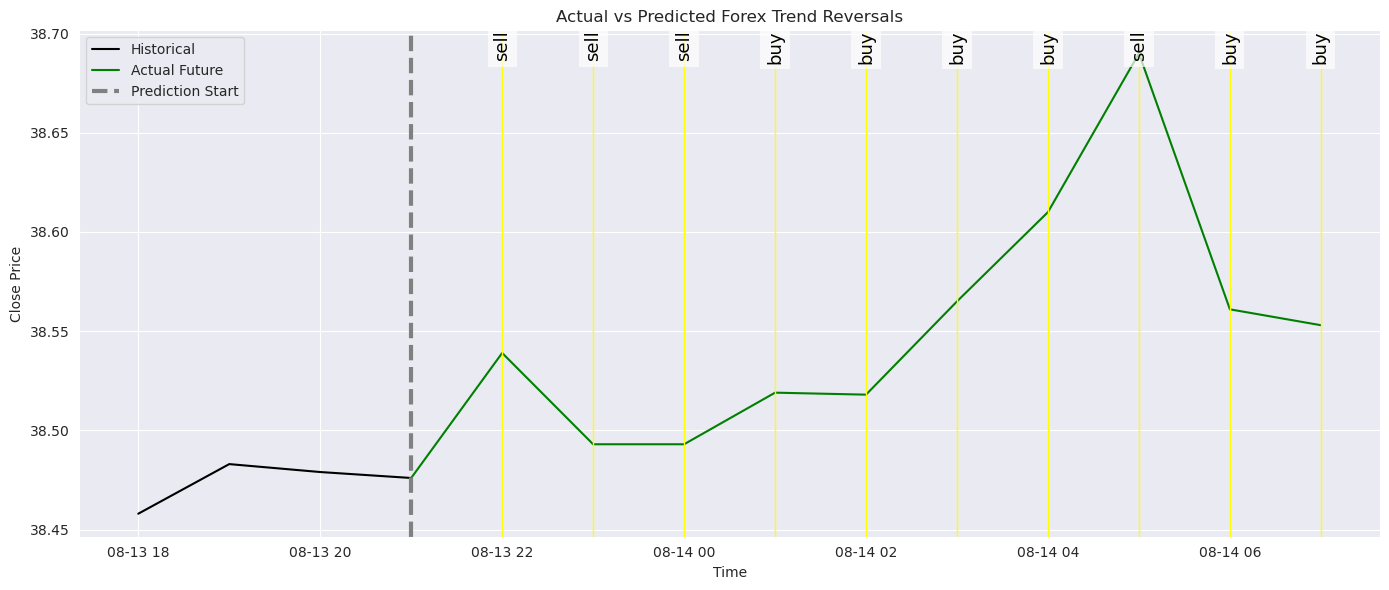

In [24]:
# --- 6. Import your plotting utility ---

import sys

sys.path.insert(1, '../utils')
import forex_plot_utils_2

# --- 7. Plot all series ---
forex_plot_utils_2.plot_all_series(
    historical_df=historical_df,
    predicted_df=predicted_df,
    actual_future_df=actual_future_df,
    title=plot_title,
    output_path=output_plot_path
)


In [25]:
# 11- Save Model with Comprehensive Report
from datetime import datetime
import os
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import time

# 11-1 Create timestamp and paths
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_filename = f'model_{timestamp}.keras'
model_path = os.path.join('saved_models', model_filename)

# 11-2 Directory to hold logs and extras
log_dir = os.path.join('saved_models', f'model_{timestamp}_logs')
os.makedirs('saved_models', exist_ok=True)
os.makedirs(log_dir, exist_ok=True)

# 11-3 Save model
print(f"\n[SAVING MODEL]")
model.save(model_path)
print(f"Model saved to: {model_path}")

# 11-4 Save scaler (IMPORTANT - needed for predictions!)
import joblib

scaler_path = os.path.join('saved_models', f'scaler_{timestamp}.pkl')
joblib.dump(scaler, scaler_path)
print(f"Scaler saved to: {scaler_path}")

# 11-5 Save training history
history_df = pd.DataFrame(history.history)
history_df.to_csv(os.path.join(log_dir, 'training_history.csv'), index=False)
print(f"Training history saved")

# 11-6 Save full history as JSON so it can be reloaded later
history_json_path = os.path.join(log_dir, 'history.json')
with open(history_json_path, 'w') as f:
    json.dump(history.history, f)

print(f"Full history object saved to: {history_json_path}")

# 11-7 Save training loss plot
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(log_dir, 'training_loss.png'))
plt.close()

# 11-8 Save accuracy plot
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(log_dir, 'training_accuracy.png'))
plt.close()

# 11-9 Evaluate on validation set (NO ONE-HOT)
eval_results = model.evaluate(X_val, y_val, verbose=0)

final_train_loss = history.history['loss'][-1]
final_train_acc = history.history['accuracy'][-1]
final_val_loss = eval_results[0]
final_val_acc = eval_results[1]

# 11-10 Generate detailed predictions for per-class analysis
print("\n[GENERATING DETAILED METRICS]")
y_val_pred_proba = model.predict(X_val, verbose=0)
y_val_pred = np.argmax(y_val_pred_proba, axis=-1)

# Flatten predictions and true labels for sklearn metrics
y_val_pred_flat = y_val_pred.flatten()
y_val_true_flat = y_val.flatten()

# Generate classification report
class_report = classification_report(
    y_val_true_flat,
    y_val_pred_flat,
    target_names=['Class 0 (No Signal)', 'Class 1 (Buy)', 'Class 2 (Sell)'],
    digits=4
)

# Generate confusion matrix
cm = confusion_matrix(y_val_true_flat, y_val_pred_flat)

# Calculate class distributions
train_class_dist = np.bincount(y_train.flatten()) / len(y_train.flatten()) * 100
val_class_dist = np.bincount(y_val.flatten()) / len(y_val.flatten()) * 100
test_class_dist = np.bincount(y_test.flatten()) / len(y_test.flatten()) * 100

# Get class weights used during training
labels_flat = y_train.flatten()
classes = np.unique(labels_flat)
from sklearn.utils.class_weight import compute_class_weight

weights = compute_class_weight('balanced', classes=classes, y=labels_flat)
class_weight_dict = {i: weights[i] for i in range(len(weights))}

# Calculate training time from history
epochs_trained = len(history.history['loss'])

# 11-11 Save confusion matrix plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1', 'Class 2'],
            yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.title('Confusion Matrix - Validation Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(log_dir, 'confusion_matrix.png'), dpi=150, bbox_inches='tight')
plt.close()

# 11-12 Save per-class performance plot
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(
    y_val_true_flat, y_val_pred_flat, average=None
)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
metrics = [precision, recall, f1]
metric_names = ['Precision', 'Recall', 'F1-Score']
colors_bar = ['#1f77b4', '#ff7f0e', '#2ca02c']

for idx, (metric, name) in enumerate(zip(metrics, metric_names)):
    axes[idx].bar(['Class 0', 'Class 1', 'Class 2'], metric, color=colors_bar)
    axes[idx].set_title(f'{name} by Class')
    axes[idx].set_ylim([0, 1.1])
    axes[idx].set_ylabel(name)
    for i, v in enumerate(metric):
        axes[idx].text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig(os.path.join(log_dir, 'per_class_metrics.png'), dpi=150, bbox_inches='tight')
plt.close()

# 11-12 Create comprehensive report
comprehensive_report = f"""
{'=' * 80}
MODEL TRAINING REPORT
{'=' * 80}
Timestamp: {timestamp}
Model Path: {model_path}
Scaler Path: {scaler_path}

{'=' * 80}
DATA CONFIGURATION
{'=' * 80}
Total Samples in df_model: {len(df_model):,}

Training Samples: {len(X_train):,} ({len(X_train) / len(df_model) * 100:.1f}%)
Validation Samples: {len(X_val):,} ({len(X_val) / len(df_model) * 100:.1f}%)
Test Samples: {len(X_test):,} ({len(X_test) / len(df_model) * 100:.1f}%)

CLASS DISTRIBUTION:
Training Set:
  - Class 0 (No Signal): {train_class_dist[0]:.2f}%
  - Class 1 (Buy Reversal): {train_class_dist[1]:.2f}%
  - Class 2 (Sell Reversal): {train_class_dist[2]:.2f}%

Validation Set:
  - Class 0 (No Signal): {val_class_dist[0]:.2f}%
  - Class 1 (Buy Reversal): {val_class_dist[1]:.2f}%
  - Class 2 (Sell Reversal): {val_class_dist[2]:.2f}%

Test Set:
  - Class 0 (No Signal): {test_class_dist[0]:.2f}%
  - Class 1 (Buy Reversal): {test_class_dist[1]:.2f}%
  - Class 2 (Sell Reversal): {test_class_dist[2]:.2f}%

FEATURE CONFIGURATION:
Features Used: {', '.join(FEATURES)}
Window Size: {WINDOW_SIZE} hours
Forecast Horizon: {FORECAST_HORIZON} hours

{'=' * 80}
TRAINING CONFIGURATION
{'=' * 80}
Optimizer: Adam (initial lr=0.001)
Loss Function: Categorical Crossentropy
Batch Size: 64
Early Stopping: patience=15, monitor=val_loss
Reduce LR: patience=7, factor=0.5

CLASS WEIGHTS (for handling imbalance):
  Class 0: {class_weight_dict[0]:.4f}
  Class 1: {class_weight_dict[1]:.4f}
  Class 2: {class_weight_dict[2]:.4f}

TRAINING PROGRESS:
Epochs Trained: {epochs_trained} / 100
Best Validation Loss Epoch: {np.argmin(history.history['val_loss']) + 1}

{'=' * 80}
MODEL ARCHITECTURE
{'=' * 80}
Total Parameters: {model.count_params():,}
Trainable Parameters: {sum([np.prod(v.shape) for v in model.trainable_weights]):,}

{'=' * 80}
OVERALL METRICS
{'=' * 80}
Final Training Loss: {final_train_loss:.6f}
Final Training Accuracy: {final_train_acc:.6f}
Final Validation Loss: {final_val_loss:.6f}
Final Validation Accuracy: {final_val_acc:.6f}

{'=' * 80}
PER-CLASS PERFORMANCE (Validation Set)
{'=' * 80}
{class_report}

{'=' * 80}
CONFUSION MATRIX (Validation Set)
{'=' * 80}
                Predicted
              Class 0  Class 1  Class 2
Actual Class 0  {cm[0][0]:6d}    {cm[0][1]:6d}    {cm[0][2]:6d}
       Class 1  {cm[1][0]:6d}    {cm[1][1]:6d}    {cm[1][2]:6d}
       Class 2  {cm[2][0]:6d}    {cm[2][1]:6d}    {cm[2][2]:6d}

{'=' * 80}
MINORITY CLASS ANALYSIS
{'=' * 80}
Class 1 (Buy Reversal):
  Total Instances: {support[1]}
  Correctly Predicted: {cm[1][1]}
  Missed (False Negatives): {cm[1][0] + cm[1][2]}
  False Positives: {cm[0][1] + cm[2][1]}

Class 2 (Sell Reversal):
  Total Instances: {support[2]}
  Correctly Predicted: {cm[2][2]}
  Missed (False Negatives): {cm[2][0] + cm[2][1]}
  False Positives: {cm[0][2] + cm[1][2]}

{'=' * 80}
FILES SAVED
{'=' * 80}
- Model: {model_filename}
- Scaler: scaler_{timestamp}.pkl
- Training History: training_history.csv
- Training Loss Plot: training_loss.png
- Training Accuracy Plot: training_accuracy.png
- Confusion Matrix: confusion_matrix.png
- Per-Class Metrics: per_class_metrics.png
- This Report: comprehensive_report.txt

{'=' * 80}
"""

# 11-13 Save comprehensive report
report_path = os.path.join(log_dir, 'comprehensive_report.txt')
with open(report_path, 'w') as f:
    f.write(comprehensive_report)

# Also save model summary separately
summary_path = os.path.join(log_dir, 'model_architecture.txt')
with open(summary_path, 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))

# Print the comprehensive report to console
print(comprehensive_report)

print(f"\n{'=' * 80}")
print(f"[SAVE COMPLETE]")
print(f"{'=' * 80}")
print(f"All files saved in: {log_dir}")
print(f"\nKey files:")
print(f"  - Comprehensive Report: {report_path}")
print(f"  - Model Architecture: {summary_path}")
print(f"  - Confusion Matrix: {os.path.join(log_dir, 'confusion_matrix.png')}")
print(f"  - Per-Class Metrics: {os.path.join(log_dir, 'per_class_metrics.png')}")


[SAVING MODEL]
Model saved to: saved_models/model_20251128_191247.keras
Scaler saved to: saved_models/scaler_20251128_191247.pkl
Training history saved
Full history object saved to: saved_models/model_20251128_191247_logs/history.json

[GENERATING DETAILED METRICS]



MODEL TRAINING REPORT
Timestamp: 20251128_191247
Model Path: saved_models/model_20251128_191247.keras
Scaler Path: saved_models/scaler_20251128_191247.pkl

DATA CONFIGURATION
Total Samples in df_model: 146,356

Training Samples: 68,746 (47.0%)
Validation Samples: 14,677 (10.0%)
Test Samples: 14,678 (10.0%)

CLASS DISTRIBUTION:
Training Set:
  - Class 0 (No Signal): 98.20%
  - Class 1 (Buy Reversal): 0.88%
  - Class 2 (Sell Reversal): 0.92%

Validation Set:
  - Class 0 (No Signal): 97.47%
  - Class 1 (Buy Reversal): 1.27%
  - Class 2 (Sell Reversal): 1.27%

Test Set:
  - Class 0 (No Signal): 97.65%
  - Class 1 (Buy Reversal): 1.19%
  - Class 2 (Sell Reversal): 1.16%

FEATURE CONFIGURATION:
Features Used: OPEN, HIGH, LOW, CLOSE, TICKVOL
Window Size: 60 hours
Forecast Horizon: 10 hours

TRAINING CONFIGURATION
Optimizer: Adam (initial lr=0.001)
Loss Function: Categorical Crossentropy
Batch Size: 64
Early Stopping: patience=15, monitor=val_loss
Reduce LR: patience=7, factor=0.5

CLASS WEIG

In [ ]:
# 1- Load model
model_path = 'saved_models/model_20251128_141712.keras'
model = keras.models.load_model(model_path)

# 2- Load scaler
scaler_path = 'saved_models/scaler_20251128_141712.pkl'
scaler = joblib.load(scaler_path)

# 3- Load history JSON
log_dir = 'saved_models/model_20251128_141712_logs'
history_json_path = os.path.join(log_dir, 'history.json')

with open(history_json_path, 'r') as f:
    history_dict = json.load(f)


# create history-like object
class ReloadedHistory:
    def __init__(self, hdict):
        self.history = hdict


history = ReloadedHistory(history_dict)

# Now you can access history just like before
print(history.history.keys())
print(history.history['loss'][:5])
